In [1]:
%matplotlib inline
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import math

input_text_file = "Fuzuli-I.txt"

with open(input_text_file, "r", encoding="utf-8") as f:
    input_text = f.read()

In [2]:
# Whitespace tokenization - letter only, stored in a dataframe
tokens = re.findall(r"\p{L}+(?:[-’']\p{L}+)*", input_text)
df = pd.DataFrame(tokens, columns=["tokens"])

df['tokens'] = df['tokens'].str.lower()

In [3]:
# Unique tokens with counts and percentage
counts = df['tokens'].value_counts()
total = counts.sum()
unique_df = pd.DataFrame({
    'token': counts.index,
    'count': counts.values,
    'frequency (%)': (counts.values/total*100).round(2)
})

# Total number of tokens
print("Token number of tokens:", total)

# Number of unique tokens
unique_count = df['tokens'].nunique() 
print("\nNumber of unique tokens:", unique_count)

# Top 15 most frequent tokens
print("\n",unique_df.head(15).to_string(index=False))

Token number of tokens: 31457

Number of unique tokens: 11294

  token  count  frequency (%)
   kim    564           1.79
    ey    479           1.52
   bir    449           1.43
    ki    424           1.35
    ol    360           1.14
    bu    288           0.92
   hər    286           0.91
   ilə    285           0.91
füzuli    270           0.86
    nə    235           0.75
   mən    154           0.49
  məni    148           0.47
   tək    141           0.45
   var    130           0.41
  mənə    117           0.37


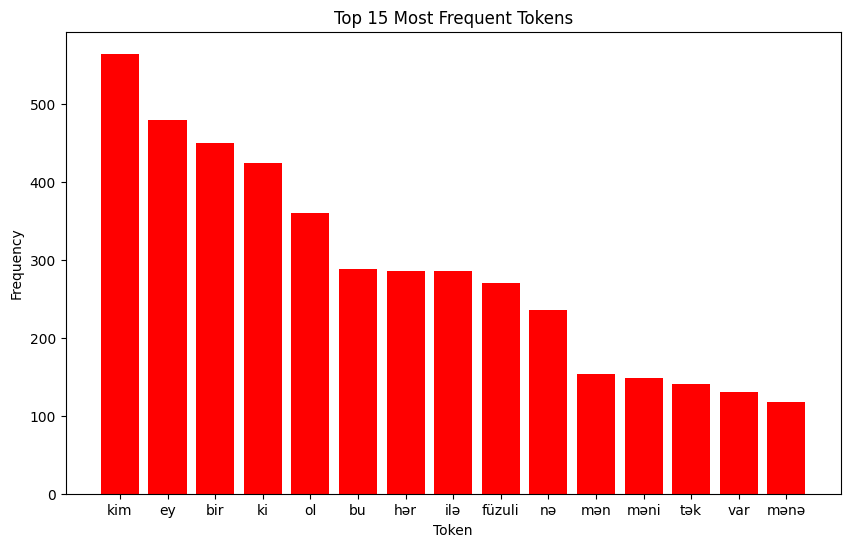

In [4]:
top15 = unique_df.head(15)

plt.figure(figsize=(10,6))
plt.bar(top15['token'], top15['count'], color="red")

plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("Top 15 Most Frequent Tokens")
plt.show()


In [5]:
# Heaps Law

def get_N_V(df):

    all_tokens = df['tokens'].tolist()
    seen = set()
    N, V = [], []

    for i, tok in enumerate(all_tokens, start=1):
        N.append(i)
        seen.add(tok)
        V.append(len(seen))

    return N, V

# linear regression
def lin_reg(N, V):

    x = [math.log(n) for n in N]
    y = [math.log(v) for v in V]

    x_mean = sum(x) / len(x)
    y_mean = sum(y) / len(y)

    # y = a + beta*x | Least Square Estimation
    beta = sum((xi - x_mean)*(yi - y_mean) for xi, yi in zip(x,y))/sum((xi - x_mean)**2 for xi in x)
    a = y_mean - beta * x_mean
    k = math.exp(a)

    return k, beta

N, V = get_N_V(df)

k, beta = lin_reg(N, V)

print("Value of k:", k, "\nValue of beta:", beta)

Value of k: 2.487568828577478 
Value of beta: 0.8148406206511912


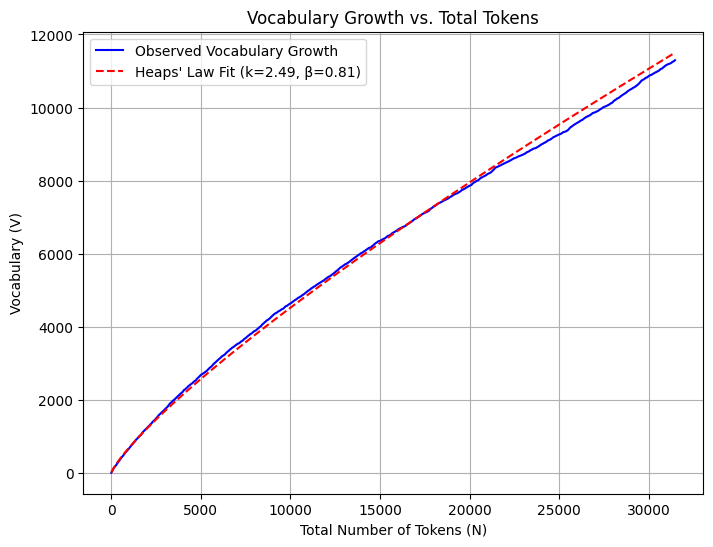

In [6]:
# Observed values
plt.figure(figsize=(8,6))
plt.plot(N, V, label="Observed Vocabulary Growth", color="blue")

# Predicted values using Heaps' law
V_pred = [k * (n ** beta) for n in N]
plt.plot(N, V_pred, label=f"Heaps' Law Fit (k={k:.2f}, β={beta:.2f})", color="red", linestyle="--")

# Labels and legend
plt.xlabel("Total Number of Tokens (N)")
plt.ylabel("Vocabulary (V)")
plt.title("Vocabulary Growth vs. Total Tokens")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
corpus = [list(token) for token in df['tokens']]

In [8]:
def sentence_segmentation(text):
    # split on ., !, ? only when followed by space or end of string
    sentence_endings = re.compile(
        r'([.!?])([\'")\]]*)(?=\s|$)'  # punctuation + optional quotes/brackets, followed by space or end
    )
    # Delimiter for splitting
    segmented = sentence_endings.sub(r'\1\2</s>', text)
    sentences = [s.strip() for s in segmented.split('</s>') if s.strip()]
    return sentences


In [9]:
def learn_bpe(corpus, num_merges):
    merges = []
    merge_freqs = []   # store (pair, frequency) at each step
    for _ in range(num_merges):
        # Count pairs fresh each iteration
        vocab = {}
        for word in corpus:
            for i in range(len(word)-1):
                pair = (word[i], word[i+1])
                vocab[pair] = vocab.get(pair, 0) + 1
        
        if not vocab:
            break
        
        # Most frequent pair
        most_frequent = max(vocab, key=vocab.get)
        merges.append(most_frequent)
        merge_freqs.append((most_frequent, vocab[most_frequent]))
        
        # Merge in corpus
        new_symbol = ''.join(most_frequent)
        new_corpus = []
        for word in corpus:
            i = 0
            new_word = []
            while i < len(word):
                if i < len(word)-1 and (word[i], word[i+1]) == most_frequent:
                    new_word.append(new_symbol)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_corpus.append(new_word)
        corpus = new_corpus
    
    return merges, corpus, merge_freqs


# Run BPE
merges, updated_corpus, merge_freqs = learn_bpe(corpus, num_merges=1000)


Top 15 frequent BPE pairs:
('ə', 'r'): 3743
('i', '-'): 3573
('ə', 'n'): 3265
('a', 'n'): 2817
('i', 'n'): 2448
('i', 'm'): 2131
('e', 'y'): 1987
('ə', 'm'): 1939
('i', 'r'): 1828
('a', 'r'): 1813
('m', 'ə'): 1539
('i', 'l'): 1426
('o', 'l'): 1360
('a', 'l'): 1229
('ə', 't'): 1086


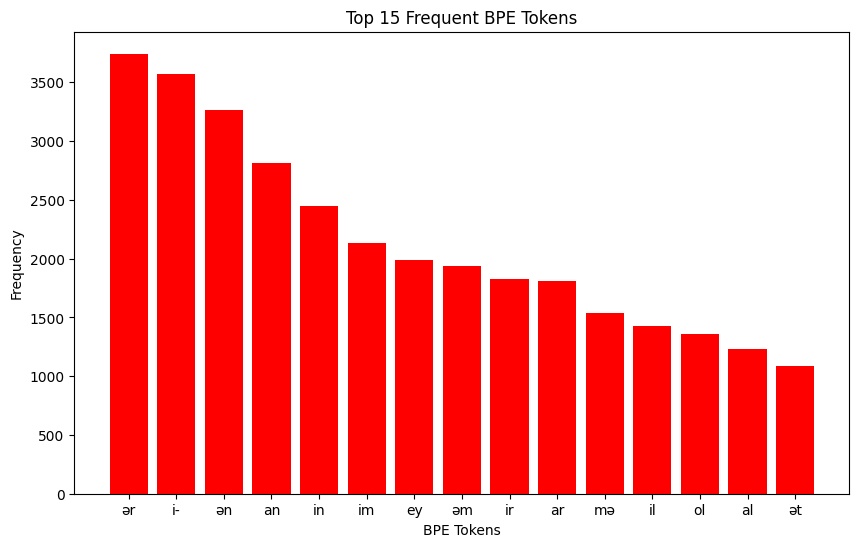

In [10]:
# Take top 15 by frequency
top15 = sorted(merge_freqs, key=lambda x: x[1], reverse=True)[:15]

# Print results
print("Top 15 frequent BPE pairs:")
for pair, freq in top15:
    print(f"{pair}: {freq}")

# Plot histogram
labels = [f"{a}{b}" for (a,b), _ in top15]
counts = [freq for _, freq in top15]

plt.figure(figsize=(10,6))
plt.bar(labels, counts, color="red")
plt.xlabel("BPE Tokens")
plt.ylabel("Frequency")
plt.title("Top 15 Frequent BPE Tokens")
plt.show()


In [11]:
def apply_bpe(text, merges):
    text = text.lower()
    # Represent word as characters
    chars = list(text)
    
    # Apply merges in the order they were learned
    for merge in merges:
        merged = ''.join(merge)
        new_chars = []
        i = 0
        while i < len(chars):
            if i < len(chars)-1 and (chars[i], chars[i+1]) == merge:
                new_chars.append(merged)
                i += 2
            else:
                new_chars.append(chars[i])
                i += 1
        chars = new_chars
    
    return ' '.join(chars)

In [12]:
sample_text = "Qəd ənarəl-eşqə-lil-üşşaqi minhacəl hüda! \
Saliki-rahi-həqiqət eşqə eylər iqtida. \
Eşqdir ol nəş’eyi-kamil kim, ondandır müdam \
Meydə təşviri-hərarət, neydə tə’siri-səda. \
Vadiyi-vəhdət, həqiqətdə, məqami-eşqdir \
Kim, müşəxxəs olmaz ol vadidə sultandan gəda. \
Eyləməz xəlvətsərayi-sirri-vəhdət məhrəmi \
Aşiqi mə’şuqdən, mə’şuqi aşiqdən cüda. \
Ey ki, əhli-eşqə söylərsən: məlamət tərkin et! \
Söylə kim, mümkünmüdür təğyiri-təqdiri-Xuda? \
Eşq kilki çəkdi xət hərfi-vücudi-aşiqə \
Kim, ola sabit həq isbatında nəfyi-maəda. \
Ey Füzuli, intihasız zövq buldun eşqdən, \
Böylədir hər iş ki, Həqq adilə qılsan ibtida. \
1 Eşq aşiqlər üçün hidayət yolunu işıqlandırdı."

In [13]:
def count_tokens(bpe_text):
    return len(bpe_text.split())


def run(sample_text):
    segmented_sentences = sentence_segmentation(sample_text)

    total_tokens = 0
    i = 0

    for sentence in segmented_sentences:
        i+=1
        res = apply_bpe(sentence, merges)
        token_count = count_tokens(res)
        total_tokens += token_count
        print(f"{i})", res, f"{token_count} tokens", "\n")
    print("Total number of tokens:", total_tokens)

run(sample_text)


1) qəd   ən ar əl- eşq ə - l il - üş şa qi   min ha c əl   hü da ! 20 tokens 

2) sal ik i- rah i- həq iq ət   eşq ə   eylər   iq ti da . 15 tokens 

3) eşq dir   ol   nə ş ’ eyi- kam il   kim ,   ondan dır   müdam   mey də   təş v iri- hər ar ət ,   ney də   tə’ sir i- sə da . 31 tokens 

4) va di yi- vəh d ət ,   həq iq ət də ,   məq am i-eşq dir   kim ,   müş əx xəs   olmaz   ol   va di də   sultan dan   gə da . 31 tokens 

5) eyləməz   xəl vət sər ayi- sir ri- vəh d ət   məh rəm i   aşiq i   mə’ şu q dən ,   mə’ şu qi   aşiq dən   cü da . 28 tokens 

6) ey   ki ,   əhli- eşq ə   s öy lər sən :   məlamət   tər kin   et ! 16 tokens 

7) s öylə   kim ,   mümkün mü dür   təğ y iri- təq dir i-x u da ? 16 tokens 

8) eşq   kil ki   çək di   xət   hər fi- vücu di- aşiq ə   kim ,   ola   sa bi t   həq   is bat ında   nəf yi- ma ə da . 28 tokens 

9) ey   füzuli ,   in ti h as ız   zövq   bul dun   eşq dən ,   böylə dir   hər   iş   ki ,   həq q   ad ilə   qıl san   ib ti da . 30 tokens 

1

In [14]:
import LevensteinBK 
with open("Fuzuli-I.txt", "r", encoding="utf-8") as infile:
    content = infile.read()

content = content.lower()
Tokens = re.findall(r"\b[^\W\d_]+(?:[\'’\-][^\W\d_]+)*\b", content)
Tokens = [t.replace("’", "'") for t in Tokens]
vocabulary = set()

for t in Tokens:
    vocabulary.add(t)


tt = LevensteinBK.BKtree(vocabulary)
search_word = "lə'li-nabın"
res = tt.search(search_word, 2)
sorted_res = sorted(res, key = lambda w:( LevensteinBK.Levenstein(w.label, search_word)))

for i in sorted_res:
    print(i)



KeyError: '̇'